# Group assignment on natural language processing

**Group members:** Suuraj Perpeli, Veikka Immonen

In this assignment we analyze performance of machine learning models
for natural language processing (NLP) tasks, using 🤗 Hugging Face.

## Install depencies

This notebook is designed to be used in Google Colab out-of-the-box (by definition of you don't have to do anything else outside of Colab session).
First, install required depencies by using pip...

In [2]:
!pip3 install -U -q datasets transformers accelerate bitsandbytes hnswlib peft wandb openai-whisper ffmpeg-python

...and import them

In [3]:
import torch

from sentence_transformers import SentenceTransformer, CrossEncoder, util
from transformers import (AutoModelForCausalLM, AutoTokenizer, pipeline,
                          BitsAndBytesConfig, TrainingArguments, Trainer,
                          DataCollatorForLanguageModeling)
from datasets import load_dataset

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from huggingface_hub import login
import wandb

import hnswlib

import os
import matplotlib.pyplot as plt
import re
import numpy as np
from tqdm import tqdm

from gensim.models.word2vec import Word2Vec

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import scipy
import io
import ffmpeg

import whisper

## Load the dataset

We chose the Medical Meadow Medical Flashcards dataset presented by Han et al. (2023) (paper [here](https://arxiv.org/pdf/2304.08247)). This is the first subset out of four published subsets, consisting of QA flashcards of medical based questions.

The dataset can be loaded using 🤗 Datasets.

In [4]:
ds = load_dataset("medalpaca/medical_meadow_medical_flashcards")
print('Structure of data: ', ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Structure of data:  DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})


The data is a dictionary ```train``` as the key and another dictionary ```Dataset```  as the value, the keys of this dictinoary are ```features``` and ```num_rows```, features being one of the ```input```, ```output```, or ```instruction```.

The ```num_rows``` suggests that there are 33955 questions and answers with instructions respectively.

Let us have a look at how each one of these are:

In [5]:
print(f'Input :', ds['train']['input'][0])
print(f'Output :', ds['train']['output'][0])
print(f'Instruction :', ds['train']['instruction'][0])

Input : What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Output : Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.
Instruction : Answer this question truthfully


The ```input```'s are questions,

The ```output```'s are answers and,

The ```instruction```'s are the instructions to answer the questions.

The dataset has also few empty prompts. Let's remove them.

In [16]:
ds = ds.filter(lambda example: len(example['input']) > 0)
ds

Filter:   0%|          | 0/33547 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33547
    })
})

## Initial analysis on the data

Let's analyze the output sentences and the train a Word2Vec model by them.

First, lowercase the text, tokenizing based on spaces to prepare the text for training. Using regex, character `\W` removes the non word characters thereby removing the '+','/','-' that however could be good to keep.

In [17]:
tokenized_sentences = [re.sub(r'\W', ' ', sentence).lower().split() for sentence in ds['train']['output']]

for i in tokenized_sentences[:5]:
  print(i)

print(f'Minimum sentence len: ', min([len(i)for i in tokenized_sentences]))
print(f'Maximum sentence len: ', max([len(i)for i in tokenized_sentences]))
print(f'Average sentence len: ', np.mean([len(i)for i in tokenized_sentences]))

['very', 'low', 'mg2', 'levels', 'correspond', 'to', 'low', 'pth', 'levels', 'which', 'in', 'turn', 'results', 'in', 'low', 'ca2', 'levels']
['low', 'estradiol', 'production', 'leads', 'to', 'genitourinary', 'syndrome', 'of', 'menopause', 'atrophic', 'vaginitis']
['low', 'rem', 'sleep', 'latency', 'and', 'experiencing', 'hallucinations', 'sleep', 'paralysis', 'suggests', 'narcolepsy']
['pth', 'independent', 'hypercalcemia', 'which', 'can', 'be', 'caused', 'by', 'cancer', 'granulomatous', 'disease', 'or', 'vitamin', 'd', 'intoxication']
['the', 'level', 'of', 'anti', 'müllerian', 'hormone', 'is', 'directly', 'related', 'to', 'ovarian', 'reserve', 'a', 'lower', 'level', 'indicates', 'a', 'lower', 'ovarian', 'reserve']
Minimum sentence len:  1
Maximum sentence len:  247
Average sentence len:  54.90207768205801


We can also visualize the "distribution" of lenght of tokenized sentences.

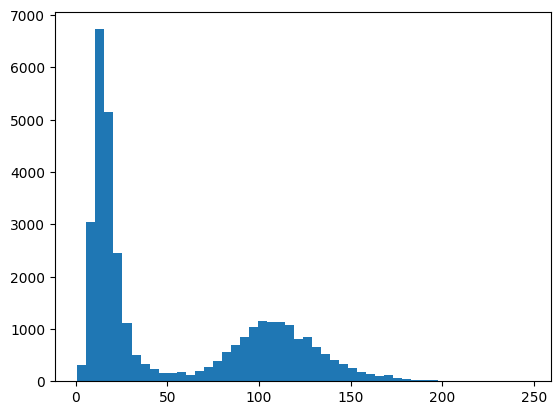

In [18]:
plt.hist([len(sen) for sen in tokenized_sentences], 50)
plt.show()

Now let's train the Word2Vec on the ```outputs```.

In [19]:
model = Word2Vec(tokenized_sentences, vector_size=100, min_count=2, window=10)
print(f'Learnt vectors: ',len(model.wv))

Learnt vectors:  17676


One thing to try is to find most similar words using different terms.


In [20]:
# term = 'sickness'
# term = 'fever'
# term = 'cure'
term = 'drugs'

sims = model.wv.most_similar(term, topn=5)
sims

[('agents', 0.8474129438400269),
 ('inhibitors', 0.7607999444007874),
 ('opioids', 0.7168576121330261),
 ('medications', 0.7164204120635986),
 ('drug', 0.6890729069709778)]

## Retrieval-based chatbot

Let's build a QA chatbot based on a semantic search pipeline. Given a question
the bot tries to find a answer from a predefined corpus.

The model can be created by using SentenceTransformers.

In [21]:
semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

Create the corpus and use Approximate Nearest Neighbor (ANN) to speed-up the search using corpus embeddings.

In [22]:
index_path = './hnswlib.index'
corpus = np.array(ds['train']['output'][:])

if not os.path.exists(index_path):
  print("Creating a HNSWLIB index")
  corpus_embeddings = semb_model.encode(corpus, convert_to_tensor=True,
                                        show_progress_bar=True)
  index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))
  index.init_index(max_elements=corpus_embeddings.size(0),
                   ef_construction=256, M=64)
  index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
  print("Saving index to:", index_path)
  index.save_index(index_path)
else:
  empty_embeddings = semb_model.encode(corpus[:1], convert_to_tensor=True)
  index = hnswlib.Index(space='cosine', dim=empty_embeddings.size(1))
  index.load_index(index_path)


Creating a HNSWLIB index


Batches:   0%|          | 0/1049 [00:00<?, ?it/s]

Saving index to: ./hnswlib.index


Test the ranking using question encoder and ANN.

In [30]:
sample = 3
query = ds['train']['input'][sample]
print(f'Query : {query}')
query_embedding = semb_model.encode(query, convert_to_tensor=True)
ids, distances = index.knn_query(query_embedding.cpu(), k=32)
out = ds['train']['output'][ids[0][np.argmin(distances[0])]]
print(f'Out : {out}')
print(f"True: {ds['train']['output'][sample]}")

Query : What are some possible causes of low PTH and high calcium levels?
Out : The likely diagnosis for the patient's condition is primary hyperparathyroidism. This condition occurs when one or more of the parathyroid glands produce too much parathyroid hormone (PTH), which can lead to high levels of calcium in the blood. Patients with primary hyperparathyroidism may also have high levels of calcium in their urine, as well as other symptoms such as fatigue, weakness, and bone pain. Treatment for primary hyperparathyroidism may involve surgery to remove the affected parathyroid gland or glands, as well as medication to manage calcium levels. Regular monitoring of calcium levels and bone density may also be necessary.
True: PTH-independent hypercalcemia, which can be caused by cancer, granulomatous disease, or vitamin D intoxication.


Test the re-ranking using the cross-encoder.

In [32]:
model_inputs = [(query, corpus[i]) for i in ids[0]]
cross_scores = xenc_model.predict(model_inputs)
print("Cross-encoder model re-ranking results")
print(f"Query: \"{query} \"")
print("-------------------------")
for idx in np.argsort(-cross_scores)[:5]:
  print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{corpus[ids[0][idx]]}\"")

Cross-encoder model re-ranking results
Query: "What are some possible causes of low PTH and high calcium levels? "
-------------------------
Score: 7.0449
Document: "Low serum calcium levels will increase PTH levels in the bloodstream. PTH is a hormone produced by the parathyroid glands that helps regulate calcium levels in the body. When calcium levels in the blood drop too low, the parathyroid glands release more PTH to stimulate the release of calcium from the bones and increase its absorption from the intestines and kidneys. This helps raise blood calcium levels back to normal. However, if low calcium levels persist, it can lead to conditions such as osteoporosis and kidney stones."
Score: 6.9603
Document: "Hypercalcemia of malignancy is a condition in which there is an abnormally high level of calcium in the blood due to cancer. This condition is often associated with low levels of parathyroid hormone (PTH), which is typically responsible for regulating calcium levels in the body.

Generate the responce function.

Note that the function `chatbot` takes a list (or `np.array`) of questions. In case of one question, put it in a list.

In [33]:
def chatbot(questions, index=index, corpus=corpus, semb_model=semb_model, xenc_model=xenc_model, top_k=32):

    questions = np.array(questions)
    question_embedding = semb_model.encode(questions, convert_to_tensor=True).cpu()
    corpus_ids, _ = index.knn_query(question_embedding, k=top_k)

    answers = corpus[corpus_ids]
    questions = np.stack([questions for _ in range(top_k)], 1)
    pairs = np.stack([questions, answers], 2)

    scores = np.stack([xenc_model.predict(pair) for pair in pairs])
    idx = np.argmax(scores, 1, keepdims=True)
    answers = np.take_along_axis(answers, idx, 1).flatten()

    return answers

Test the chatbot.

In [43]:
start, end = 3000, 3600
questions = np.array(ds['train']['input'])[start:end]
true = corpus[start:end]

batch_size = 64
iterator = tqdm(range(0, len(questions), batch_size))
pred = np.concatenate([chatbot(questions[i: i+batch_size]) for i in iterator])

print((pred == true).mean())


100%|██████████| 10/10 [00:47<00:00,  4.75s/it]

0.9166666666666666


## Integrating speech-to-text and text-to-speech functionality

In [44]:
!mkdir ./tmp

In [45]:
model = whisper.load_model("base")


  0%|                                               | 0.00/139M [00:00<?, ?iB/s]
  4%|█▌                                    | 5.75M/139M [00:00<00:02, 60.2MiB/s]
 13%|████▊                                 | 17.4M/139M [00:00<00:01, 96.2MiB/s]
 22%|████████▌                              | 30.5M/139M [00:00<00:00, 115MiB/s]
 30%|███████████▍                          | 41.5M/139M [00:00<00:01, 81.4MiB/s]
 39%|██████████████▊                       | 53.9M/139M [00:00<00:00, 95.3MiB/s]
 47%|██████████████████▏                    | 64.7M/139M [00:00<00:00, 100MiB/s]
 54%|█████████████████████                  | 75.0M/139M [00:00<00:00, 101MiB/s]
 64%|████████████████████████▉              | 88.6M/139M [00:00<00:00, 113MiB/s]
 72%|████████████████████████████           | 99.8M/139M [00:01<00:00, 105MiB/s]
 81%|████████████████████████████████▍       | 112M/139M [00:01<00:00, 112MiB/s]
 90%|███████████████████████████████████▉    | 124M/139M [00:01<00:00, 116MiB/s]
100%|██████████████████████

In [60]:
tts_utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
  1%|          | 5/525 [25:08<43:35:05, 301.74s/it]
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/entrypoints.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to constru

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [65]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/entrypoints.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please ope

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [48]:
"""
References:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])

    process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)

    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))

    return audio, sr

In [84]:
audio, sr = get_audio()

In [87]:
audio / sr

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -4.16666667e-05, -2.08333333e-05, -2.08333333e-05])

In [88]:
scipy.io.wavfile.write('./tmp/recording.wav', sr, audio)

In [89]:
recording = whisper.load_audio("./tmp/recording.wav")
recording = whisper.pad_or_trim(recording)

In [58]:
mel = whisper.log_mel_spectrogram(recording).to(model.device)

# Use the mel spectrogram to detect the language
_, probs = model.detect_language(mel)
lang = max(probs, key=probs.get)

# Print result
print(f"Detected language: {lang}, confidence: {probs[lang]}")

Detected language: en, confidence: 0.7134137153625488


In [59]:
# decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)


Testing, testing, one, two, three. Can you hear me?


In [90]:
sequences, lengths = tts_utils.prepare_input_sequence([result.text])
sequences

tensor([[57, 42, 56, 57, 46, 51, 44,  6, 11, 57, 42, 56, 57, 46, 51, 44,  6, 11,
         52, 51, 42,  6, 11, 57, 60, 52,  6, 11, 57, 45, 55, 42, 42,  7, 11, 40,
         38, 51, 11, 62, 52, 58, 11, 45, 42, 38, 55, 11, 50, 42, 10]],
       device='cuda:0')

In [91]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)

In [92]:
with torch.no_grad():
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050
Audio(audio_numpy, rate=rate)

In [83]:
scipy.io.wavfile.write('./tmp/recording.wav', rate, audio_numpy)

In [124]:
def s2s_chatbot(rate=22050):

    input_audio, input_rate = get_audio()
    scipy.io.wavfile.write('./tmp/tmp_in.wav', input_rate, input_audio)

    recording_in = whisper.load_audio("./tmp/tmp_in.wav")
    recording_in = whisper.pad_or_trim(recording_in)

    mel = whisper.log_mel_spectrogram(recording_in).to(model.device)
    options = whisper.DecodingOptions(fp16 = False)
    result = whisper.decode(model, mel, options)

    answer = chatbot([result.text])

    sequences, lengths = tts_utils.prepare_input_sequence(answer)
    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)
        audio = waveglow.infer(mel)
    audio_numpy = audio[0].data.cpu().numpy()

    return result.text, answer[0], Audio(audio_numpy, rate=rate)


In [125]:
question_text, answer_text, answer_audio = s2s_chatbot()

In [126]:
print(question_text)
print(answer_text)
answer_audio

What is a T-test?
The t-test is a commonly used statistical test to check for differences between the means of two groups.


## Generative Chatbot

Download the model and tokenizer, model as quantized

In [ ]:
name = "gpt2"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
corpus = ds['train']['output'][:100]    # create a corpus of 100 docs
model = SentenceTransformer('all-mpnet-base-v2')
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

In [66]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_use_double_quant=True)

model = AutoModelForCausalLM.from_pretrained(name, device_map="auto",
                                             bos_token_id=tokenizer.bos_token_id,
                                             eos_token_id=tokenizer.eos_token_id,
                                             quantization_config=quantization_config)

NameError: name 'name' is not defined

In [ ]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Linear4bit(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear4bit(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear4bit(in_features=3072, out_features=768, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_a

Format data for training

In [ ]:
alpaca_prompt = """Instruction: {}

Question: {}

Answer: {}"""

def format(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output)
        texts.append(text)
    return {"text": texts}


ds = ds.map(format, batched=True)

print(ds)
print(ds['train']['text'][0])

Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'text'],
        num_rows: 33955
    })
})
Instruction: Answer this question truthfully

Question: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?

Answer: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


In [ ]:
plt.hist([len(sample['text'].split()) for sample in ds['train']], 50)
plt.show()

KeyError: 'text'

In [ ]:
max_length = 400

def tokenize(examples):
    inputs = tokenizer(examples["text"], truncation=True,
                       max_length=max_length, return_overflowing_tokens=True)
    return inputs

ds_encoded = ds.map(tokenize, batched=True, remove_columns=ds["train"].column_names)
ds_encoded

Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'overflow_to_sample_mapping'],
        num_rows: 33955
    })
})

Create LoRA configuration for QLoRA

In [ ]:
adapter_configs = {
    'target_modules': 'all-linear',
    'lora_alpha': 2,
    'lora_dropout': 0.05,
    'r': 4,
    'bias': 'none',
    'task_type': 'CAUSAL_LM'
}

lora_configs = LoraConfig(**adapter_configs)

prepared_model_4bit = prepare_model_for_kbit_training(model)
qlora_model = get_peft_model(prepared_model_4bit, lora_configs)

qlora_model.print_trainable_parameters()

trainable params: 589,824 || all params: 125,029,632 || trainable%: 0.4717


In [ ]:
data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
wandb.init(mode="disabled")

In [ ]:
sample = [ds_encoded['train'][i]['input_ids'] for i in range(1)]
collated = data_collator(sample)

print(collated.keys())

dict_keys(['input_ids', 'labels'])


In [ ]:
train_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    bf16=True,
    logging_steps=8,
    output_dir="outputs",
)
trainer = Trainer(
    model=qlora_model,
    processing_class=tokenizer,
    train_dataset=ds_encoded['train'],
    args=train_args,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
8,23.411100
16,23.570500
24,23.278800
32,22.556300
40,22.106700
48,21.893400
56,21.469300
64,20.767900
72,20.304300
80,20.106800


## Training wrapper with Lightning (not used)

Create collat function for tokenized inputs/outputs

In [ ]:
def collate(mini_batch):
    input_encodings = tokenizer([sample['text'] for sample in mini_batch], return_tensors='pt', padding=True)
    labels = input_encodings.input_ids.clone()
    labels[~input_encodings.attention_mask.bool()] = -100

    return input_encodings, labels

data_loader = DataLoader(
    ds['train'], collate_fn=collate, shuffle=True, batch_size=16
)

Wrap model into a PyTorch Lightning module

In [ ]:
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 42.4 MB/s eta 0:00:00


In [ ]:
import lightning as L
from torch.optim import AdamW
import torch.nn.functional as F

class LightningWrapper(L.LightningModule):
    def __init__(self, model, tokeniser, lr=1.e-5):
        super().__init__()
        self._model = model
        self._tokeniser = tokeniser
        self._lr = lr

    def configure_optimizers(self):
        # Build optimiser
        optimiser = AdamW(self.parameters(), lr=self._lr)

        return optimiser

    def forward(self, *args, **kwargs):
        return self._model.forward(*args, **kwargs)

    def training_step(self, mini_batch, mini_batch_idx):
        # Unpack the encoding and the target labels
        input_encodings, labels = mini_batch
        # Run generic forward step
        output = self.forward(**input_encodings)
        # Compute logits
        logits: torch.tensor = output.logits
        # Shift logits to exclude the last element
        logits = logits[..., :-1, :].contiguous()
        # shift labels to exclude the first element
        labels = labels[..., 1:].contiguous()
        # Compute LM loss token-wise
        loss: torch.tensor = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))

        return loss

lightning_model = LightningWrapper(qlora_model, tokenizer)

Training

In [ ]:
trainer = L.Trainer(
    accumulate_grad_batches=32,
    precision='bf16-mixed',  # Mixed precision (bf16-mixed or 16-mixed)
    gradient_clip_val=1.0,  # Gradient clipping
    max_epochs=1
)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(lightning_model, train_dataloaders=data_loader)